# Zadanie domowe: generator obrazów psów
### Autorzy:
* Wojciech Rosenthal, indeks 180458
* Grzegorz Pozorski, indeks 180169
### Informacje:
* Grupa: Uczenie maszynowe 2
* Przedmiot: Uczenie głębokie
* Data: 22.01.2024 r.
* Specjalność: Uczenie maszynowe

# I przygotowanie danych

In [1]:
import numpy as np
import tensorflow as tf
import cv2
import time
import torch
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

import os
import random

print(tf.__version__)

2.10.0


In [2]:
IMAGE_WIDTH=64
IMAGE_HEIGHT=64
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [4]:
dirpath = 'kagglecatsanddogs_5340/PetImages/Dog/'
filenames = [filename for filename in os.listdir(dirpath) if filename.endswith(".jpg")]
print(f"Total number of images: {len(filenames)}")

FileNotFoundError: [WinError 3] System nie może odnaleźć określonej ścieżki: 'kagglecatsanddogs_5340/PetImages/Dog/'

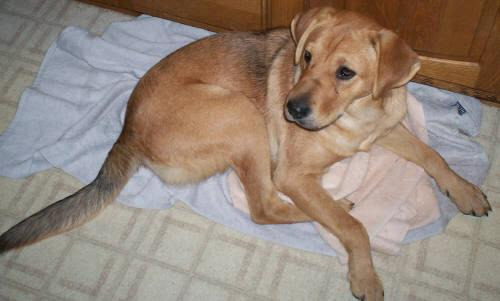

In [7]:
sample = dirpath + random.choice(filenames)
img = Image.open(sample)
display(img)

### Wykrycie psów na obrazach i przycięcie ich

In [8]:
def make_square(image):
    height, width = image.shape[:2]

    max_side = max(height, width)
    top = bottom = left = right = 0

    if height < max_side:
        diff = max_side - height
        top = diff // 2
        bottom = diff - top
    elif width < max_side:
        diff = max_side - width
        left = diff // 2
        right = diff - left

    mean_color = cv2.mean(image)
    mean_color = tuple(map(int, mean_color))
    padded_image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=mean_color)

    return padded_image

In [9]:
preprocessed_dirpath = 'kagglecatsanddogs_5340/PetImages/Dog-preprocessed/'

if not os.path.exists(preprocessed_dirpath):
    os.makedirs(preprocessed_dirpath)

In [11]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', force_reload=True, trust_repo=True)

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /home/wojtero/.cache/torch/hub/master.zip


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 2.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 701.1/701.1 kB 7.0 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 7.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 34.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 40.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.7/310.7 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 34.8 MB/s eta 0:00:0

YOLOv5 🚀 2024-1-20 Python-3.10.12 torch-2.1.2+cu121 CUDA:0 (NVIDIA GeForce RTX 4080, 16057MiB)

100.0%

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


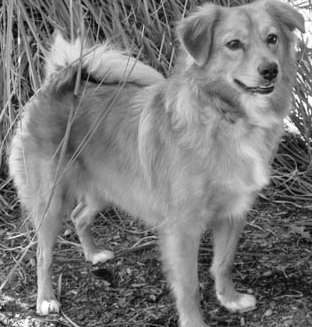

In [12]:
sample = 'kagglecatsanddogs_5340/PetImages/Dog/' + '10003.jpg'
image = cv2.imread(sample, cv2.IMREAD_COLOR)
results = model(image)

pd_results = results.pandas().xyxy[0]
pd_results = pd_results[pd_results['name'] == 'dog']
pd_results = pd_results[pd_results['confidence'] > 0.5]
top, bottom, left, right = pd_results[['ymax', 'ymin', 'xmin', 'xmax']].values[0]
left, right, top, bottom = round(left), round(right), round(top), round(bottom)

image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cropped_image = image[bottom:top, left:right]

img = Image.fromarray(cropped_image)
display(img)

In [13]:
def process_image(filename, dirpath, preprocessed_dirpath):
    try:
        image = cv2.imread(dirpath + filename, cv2.IMREAD_COLOR)
        width, height = image.shape[:2]
        
        results = model(image) 
        
        pd_results = results.pandas().xyxy[0]
        pd_results = pd_results[pd_results['name'] == 'dog']
        pd_results = pd_results[pd_results['confidence'] > 0.5]
        if len(pd_results) == 0:
            return None
        top, bottom, left, right = pd_results[['ymax', 'ymin', 'xmin', 'xmax']].values[0]
        left, right, top, bottom = round(left), round(right), round(top), round(bottom)
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        cropped_image = image[bottom:top, left:right]
        
        padded_image = make_square(cropped_image)
        padded_resized_image = cv2.resize(padded_image, IMAGE_SIZE)
        
        cv2.imwrite(preprocessed_dirpath + filename, padded_resized_image)
        
        return width, height
    except Exception as e:
        raise Exception(f"Error processing {filename}: {e}")


In [ ]:
mean_size = np.zeros(2)
cnt = 0

start_time = time.time()
for filename in filenames:
    try:
        shape = process_image(filename, dirpath, preprocessed_dirpath)
        if shape:
            mean_size += np.array(shape[:2])
            cnt += 1
    except Exception as e:
        print(f"An error occurred: {e}")

end_time = time.time()
print(f"Total time: {end_time - start_time}")
print(f"Mean size: {mean_size / cnt}.\nTotal count: {cnt}")

### -------------------
# Total time: 1510.6200618743896
# Mean size: [        381       420.6].
# Total count: 6487

# VAE

In [110]:
preprocessed_dirpath = 'kagglecatsanddogs_5340/PetImages/Dog-preprocessed/'
filenames = [filename for filename in os.listdir(preprocessed_dirpath)]
print(f"Total number of images: {len(filenames)}")

Total number of images: 6487


In [115]:
X = np.zeros((len(filenames), IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.uint8)
for filename in filenames:
    image = cv2.imread(preprocessed_dirpath + filename, cv2.IMREAD_GRAYSCALE)
    X[filenames.index(filename)] = image.reshape(IMAGE_HEIGHT, IMAGE_WIDTH, 1)
    
X_orig = X.copy()

print(X.shape)

(6487, 64, 64, 1)


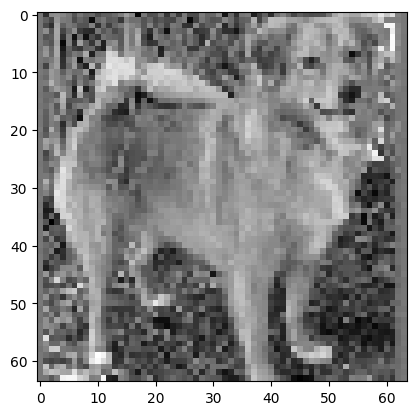

In [116]:
plt.imshow(X[4].reshape(64, 64, 1), cmap='gray')

In [117]:
ratio = 0.8

X = X_orig.copy()

split_index = round(X.shape[0] * ratio)
X_train_val = X[:split_index]
X_test = X[split_index:]

split_index_train_val = round(X_train_val.shape[0] * ratio)
X_train = X_train_val[:split_index_train_val]
X_val = X_train_val[split_index_train_val:]

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (4152, 64, 64, 1)
Validation set shape: (1038, 64, 64, 1)
Test set shape: (1297, 64, 64, 1)


In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.metrics import *

In [8]:
# Please notice - padding="same", so padding is used and no change in spatial resolution is observed
def conv2D_block(input, num_filters, act="gelu", padd="same", k_init="he_normal"):
    conv = Conv2D(num_filters, (3, 3), activation=act, padding=padd, kernel_initializer=k_init)(input)
    conv = Conv2D(num_filters, (3, 3), activation=act, padding=padd, kernel_initializer=k_init)(conv)
    return conv

In [9]:
# Single encoder block
def encoder_block(input, num_filters):
    conv = conv2D_block(input, num_filters)
    pool = MaxPooling2D((2, 2))(conv)
    return conv, pool

In [10]:
# Single decoder block
def decoder_block(input, skip_conn, num_filters):
    uconv = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    con = concatenate([uconv, skip_conn])
    out = conv2D_block(con, num_filters)
    return out

In [11]:
# Build the model: use encoder block and decoder block
def build_model(input_shape, num_channels=1):
    input_layer = Input(input_shape)

    # Encoder
    c1, p1 = encoder_block(input_layer, 32)
    c2, p2 = encoder_block(p1, 64)  # Additional encoder block

    # Bottleneck
    b1 = conv2D_block(p2, 128)  # output -> (16, 16, 128)

    # Decoder
    d1 = decoder_block(b1, c2, 64)
    d2 = decoder_block(d1, c1, 32)  # Additional decoder block

    # Output
    output_layer = Conv2D(num_channels, (1, 1), padding="same", activation="sigmoid")(d2)

    model = Model(inputs=input_layer, outputs=output_layer, name="ImageAutoencoder")
    return model

In [17]:
# source: https://colab.research.google.com/drive/12kzkT9E-iPCv2zsgTcag8y2Cm9FNDn0_#scrollTo=78wlGjisb2Cg
# BUT extended
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model = build_model(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 1))
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[RootMeanSquaredError()])

In [18]:
model.summary()

Model: "ImageAutoencoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 1)]          0         []                            
                                                                                                  
 conv2d_11 (Conv2D)          (None, 64, 64, 32)           320       ['input_2[0][0]']             
                                                                                                  
 conv2d_12 (Conv2D)          (None, 64, 64, 32)           9248      ['conv2d_11[0][0]']           
                                                                                                  
 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 32)           0         ['conv2d_12[0][0]']           
 g2D)                                                                              

In [19]:
history = model.fit(X_train, X_train, epochs = 300, validation_data = (X_val, X_val))

Epoch 1/300
130/130 [==============================] - 2s 8ms/step - loss: 16124.4082 - root_mean_squared_error: 126.9819 - val_loss: 16267.4531 - val_root_mean_squared_error: 127.5439
Epoch 2/300
130/130 [==============================] - 1s 7ms/step - loss: 16124.4033 - root_mean_squared_error: 126.9819 - val_loss: 16267.4531 - val_root_mean_squared_error: 127.5439
Epoch 3/300
130/130 [==============================] - 1s 7ms/step - loss: 16124.4043 - root_mean_squared_error: 126.9819 - val_loss: 16267.4531 - val_root_mean_squared_error: 127.5439
Epoch 4/300
130/130 [==============================] - 1s 7ms/step - loss: 16124.4043 - root_mean_squared_error: 126.9819 - val_loss: 16267.4531 - val_root_mean_squared_error: 127.5439
Epoch 5/300
130/130 [==============================] - 1s 7ms/step - loss: 16124.4043 - root_mean_squared_error: 126.9819 - val_loss: 16267.4531 - val_root_mean_squared_error: 127.5439
Epoch 6/300
130/130 [==============================] - 1s 7ms/step - loss: 

In [37]:
import matplotlib.pyplot as plt

def compare_images(image, generated_image):

    fig, ax = plt.subplots(1,2, figsize=(12,6))

    ax[0].imshow(image, cmap='gray')
    ax[0].set_title('Image')
    ax[1].imshow(generated_image, cmap='gray')
    ax[1].set_title('Generated image')

    plt.show()

(1298, 64, 64, 1)
1/1 [==============================] - 0s 9ms/step


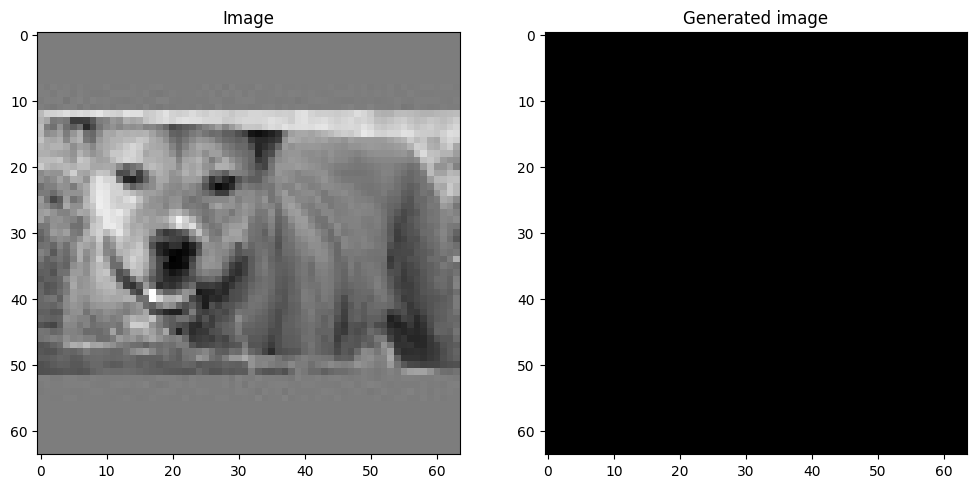

1/1 [==============================] - 0s 9ms/step


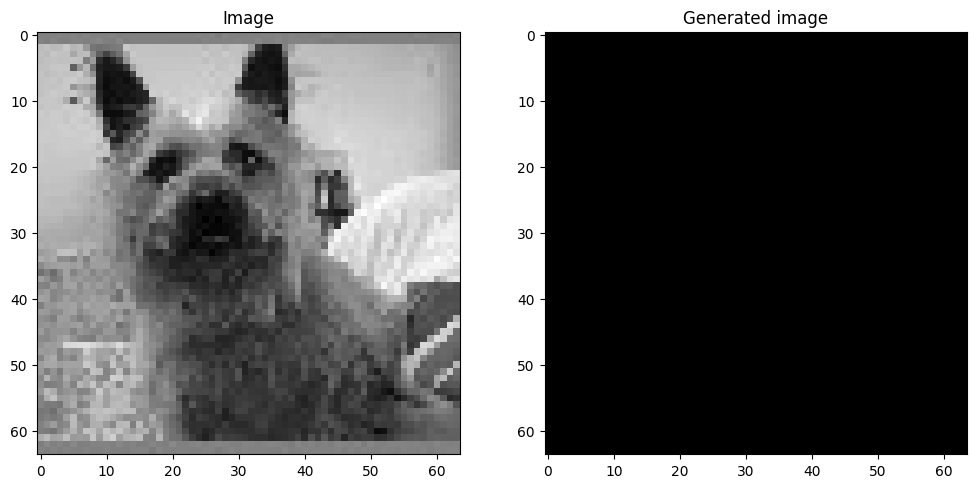

In [21]:
sample_size = 2
print(X_test.shape)
sample = np.random.randint(0, X_test.shape[0], sample_size)
for i in range(sample_size):
    compare_images(X_test[sample[i]], model.predict(np.expand_dims(X_test[sample[i]], 0))[0])

In [ ]:
# TODO:
# - FIX
# - make VAE model
# - save model
# - plot history
# - test model

# VAE 2

In [119]:
X_train_vae = X_train / 255.
X_valid_vae = X_val / 255.

In [75]:
import tensorflow.keras as keras
K = keras.backend

In [130]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [149]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

In [132]:
codings_size = 1024

inputs = keras.layers.Input(shape=[64, 64])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

In [133]:
decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(64 * 64, activation="sigmoid")(x)
outputs = keras.layers.Reshape([64, 64])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

In [134]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

In [135]:
latent_loss = -0.5 * K.sum(1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean), axis=-1)
variational_ae.add_loss(K.mean(latent_loss))
variational_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=[rounded_accuracy])

In [136]:
history = variational_ae.fit(X_train_vae, X_train_vae, epochs=100, batch_size=128, validation_data=(X_valid_vae, X_valid_vae))

Epoch 1/100
33/33 [==============================] - 1s 6ms/step - loss: 64.8798 - rounded_accuracy: 0.5665 - val_loss: 9.2729 - val_rounded_accuracy: 0.6128
Epoch 2/100
33/33 [==============================] - 0s 3ms/step - loss: 5.1234 - rounded_accuracy: 0.6165 - val_loss: 3.3347 - val_rounded_accuracy: 0.6059
Epoch 3/100
33/33 [==============================] - 0s 3ms/step - loss: 2.5794 - rounded_accuracy: 0.5981 - val_loss: 2.2933 - val_rounded_accuracy: 0.5892
Epoch 4/100
33/33 [==============================] - 0s 3ms/step - loss: 2.0123 - rounded_accuracy: 0.5946 - val_loss: 1.9210 - val_rounded_accuracy: 0.5858
Epoch 5/100
33/33 [==============================] - 0s 3ms/step - loss: 1.7303 - rounded_accuracy: 0.5974 - val_loss: 1.6969 - val_rounded_accuracy: 0.5929
Epoch 6/100
33/33 [==============================] - 0s 3ms/step - loss: 1.5478 - rounded_accuracy: 0.5976 - val_loss: 1.5587 - val_rounded_accuracy: 0.5898
Epoch 7/100
33/33 [==============================] - 0s 3

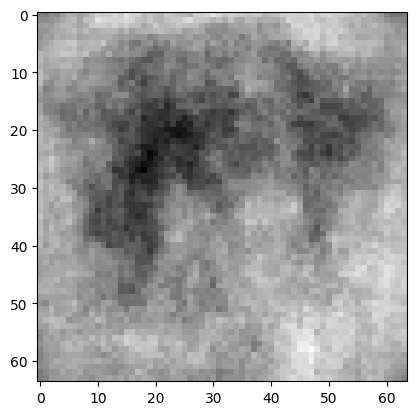

In [138]:
codings = tf.random.normal(shape=[1, codings_size])
images = variational_decoder(codings).numpy()
plt.imshow(images[0], cmap='gray')

In [139]:
def compare_images(image, generated_image):
    fig, ax = plt.subplots(1,2, figsize=(12,6))
    ax[0].imshow(image, cmap='gray')
    ax[0].set_title('Image')
    ax[1].imshow(generated_image, cmap='gray')
    ax[1].set_title('Generated image')
    plt.show()

In [140]:
X_test_vae = X_test / 255.

(1298, 64, 64, 1)
1/1 [==============================] - 0s 73ms/step


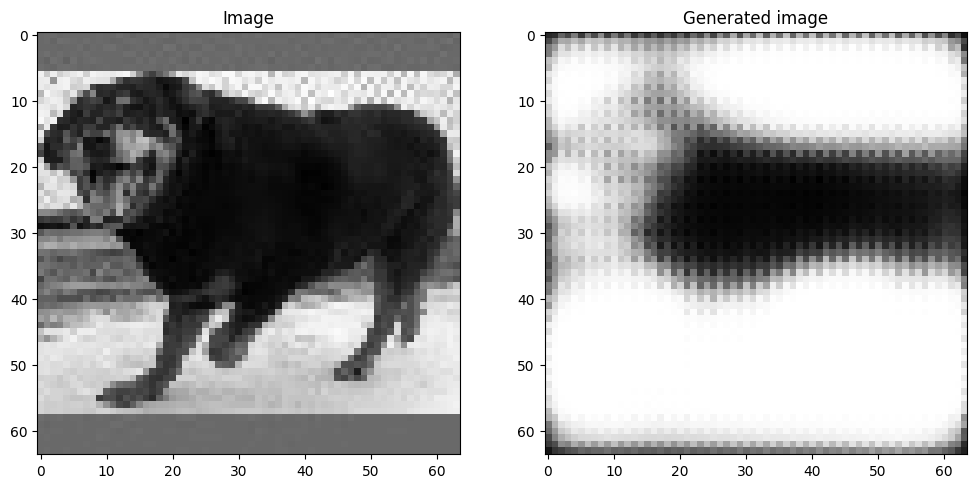

1/1 [==============================] - 0s 10ms/step


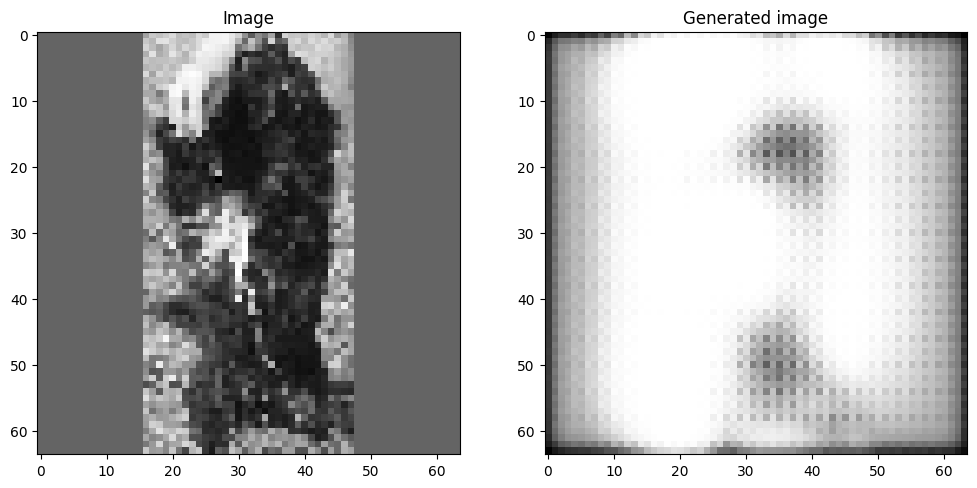

In [141]:
sample_size = 2
print(X_test.shape)
sample = np.random.randint(0, X_test.shape[0], sample_size)
for i in range(sample_size):
    compare_images(X_test_vae[sample[i]], model.predict(np.expand_dims(X_test_vae[sample[i]], 0))[0])

# VAE 3

In [8]:
import tensorflow.keras as keras
K = keras.backend

In [9]:
X_train_vae = X_train / 255.
X_valid_vae = X_val / 255.
X_test_vae = X_test / 255.

In [10]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

In [48]:
class VariationalDeepAutoencoder(tf.keras.models.Model):
  def __init__(self, data_shape, latent_dimension, encoder_activation, decoder_activation, padding='same'):
    super(VariationalDeepAutoencoder, self).__init__()
    self.latent_dimension = latent_dimension
    self.rows_columns = int(np.sqrt(latent_dimension))
    self.model_name = "Variational Deep Autoencoder"

    input = tf.keras.layers.Input(shape=data_shape)
    layer = tf.keras.layers.Conv2D(32, 3, activation=encoder_activation, padding=padding)(input)
    layer = tf.keras.layers.MaxPool2D(2)(layer)
    layer = tf.keras.layers.Conv2D(64, 3, activation=encoder_activation, padding=padding)(layer)
    layer = tf.keras.layers.MaxPool2D(2)(layer)
    layer = tf.keras.layers.Conv2D(128, 3, activation=encoder_activation, padding=padding)(layer)
    layer = tf.keras.layers.LayerNormalization()(layer)
    layer = tf.keras.layers.Flatten()(layer)
    self.encoding_mean = keras.layers.Dense(self.latent_dimension)(layer)
    self.encoding_log_var = keras.layers.Dense(self.latent_dimension)(layer)
    self.encoding = Sampling()([self.encoding_mean, self.encoding_log_var])

    self.encoder = keras.models.Model(inputs=[input], outputs=[self.encoding_mean, self.encoding_log_var, self.encoding])
    # _, _, self.encoding = self.encoder(input)

    self.decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(self.latent_dimension, activation=decoder_activation),
      tf.keras.layers.Reshape((self.rows_columns, self.rows_columns, data_shape[2])),
      tf.keras.layers.UpSampling2D((2, 2), interpolation="nearest"),
      tf.keras.layers.Conv2D(64, 3, activation=decoder_activation, padding=padding),
      #tf.keras.layers.UpSampling2D((2,2), interpolation="nearest"),
      #tf.keras.layers.Conv2D(32, 3, activation=decoder_activation, padding=padding),
      tf.keras.layers.Conv2D(1, 1),
      tf.keras.layers.Activation("sigmoid")
    ])

  def call(self, x):
    _, _, encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [49]:
latent_dimension = 1024
encoder_activation = 'relu'
decoder_activation = 'sigmoid'
epochs = 20

model = VariationalDeepAutoencoder(X_train_vae.shape[1:], latent_dimension, encoder_activation, decoder_activation)
latent_loss = -0.5 * K.sum(1 + model.encoding_log_var - K.exp(model.encoding_log_var) - K.square(model.encoding_mean), axis=-1)
model.add_loss(latent_loss)
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.001))

model.fit(X_train_vae, X_train_vae, epochs=epochs, shuffle=True, validation_data=(X_valid_vae, X_valid_vae))

Epoch 1/20


ValueError: in user code:

    File "/home/wojtero/PycharmProjects/vae-ug-homework/venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/home/wojtero/PycharmProjects/vae-ug-homework/venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/wojtero/PycharmProjects/vae-ug-homework/venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/home/wojtero/PycharmProjects/vae-ug-homework/venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/wojtero/PycharmProjects/vae-ug-homework/venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/home/wojtero/PycharmProjects/vae-ug-homework/venv/lib/python3.10/site-packages/keras/src/engine/compile_utils.py", line 328, in __call__
        total_total_loss_mean_value = tf.add_n(total_loss_mean_values)
    File "/home/wojtero/PycharmProjects/vae-ug-homework/venv/lib/python3.10/site-packages/keras/src/layers/core/tf_op_layer.py", line 119, in handle
        return TFOpLambda(op)(*args, **kwargs)
    File "/home/wojtero/PycharmProjects/vae-ug-homework/venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer "tf.math.add_n_9" (type TFOpLambda).
    
    Shapes must be equal rank, but are 0 and 1
    	From merging shape 0 with other shapes. for '{{node tf.math.add_n_9/AddN}} = AddN[N=2, T=DT_FLOAT](tf.math.add_n_9/AddN/binary_crossentropy/weighted_loss/value, Placeholder)' with input shapes: [], [?].
    
    Call arguments received by layer "tf.math.add_n_9" (type TFOpLambda):
      • inputs=['tf.Tensor(shape=(), dtype=float32)', 'tf.Tensor(shape=(None,), dtype=float32)']
      • name=None


# VAE 4

In [62]:
class DeepVae(tf.keras.Model):
    def __init__(self, latent_dimension):
        super(DeepVae, self).__init__()

        self.latent_dim = latent_dimension

        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(64, 64, 1)),
            tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ])

        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=16*16*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(16, 16, 32)),
            tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same'),
        ])

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [64]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(-0.5 * ((sample - mean) ** 2.0 * tf.exp(-logvar) + logvar + log2pi), axis=raxis)


def compute_loss(model, x, beta = 1.0):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + beta * (logpz - logqz_x))


@tf.function
def train_step(model, x, optimizer, beta = 1.0):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x, beta)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [65]:
epochs = 300
annealing_cycles = 4
latent_dim = 1024

In [63]:
model = DeepVae(latent_dimension)
model.encoder.summary()
model.decoder.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 31, 31, 32)        320       
                                                                 
 conv2d_21 (Conv2D)          (None, 15, 15, 64)        18496     
                                                                 
 flatten_10 (Flatten)        (None, 14400)             0         
                                                                 
 dense_20 (Dense)            (None, 2048)              29493248  
                                                                 
Total params: 29,512,064
Trainable params: 29,512,064
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense) 

In [66]:
optimizer = tf.keras.optimizers.Adam(1e-4)

train_size = X_train.shape[0]
val_size = X_val.shape[0]
test_size = X_test.shape[0]

batch_size = 128

train_dataset = (tf.data.Dataset.from_tensor_slices(X_train.astype(np.float32)).shuffle(train_size).batch(batch_size))
val_dataset = (tf.data.Dataset.from_tensor_slices(X_val.astype(np.float32)).shuffle(val_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(X_test.astype(np.float32)).shuffle(test_size).batch(batch_size))

In [67]:
annealing_cycle_length = epochs // annealing_cycles

for epoch in range(1, epochs + 1):
  start_time = time.time()
  beta = float(int(epoch) % int(annealing_cycle_length)) / annealing_cycle_length
  for train_x in train_dataset:
    train_step(model, train_x, optimizer, beta)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for val_x in test_dataset:
    loss(compute_loss(model, val_x, beta))
  elbo = -loss.result()
  print('Epoch: {}, Validation set ELBO: {}, beta: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, beta, end_time - start_time))

Epoch: 1, Validation set ELBO: -43.40739822387695, beta: 0.013333333333333334, time elapse for current epoch: 1.7944436073303223
Epoch: 2, Validation set ELBO: -46.885414123535156, beta: 0.02666666666666667, time elapse for current epoch: 1.4155099391937256
Epoch: 3, Validation set ELBO: -44.647796630859375, beta: 0.04, time elapse for current epoch: 1.3386249542236328
Epoch: 4, Validation set ELBO: -44.086387634277344, beta: 0.05333333333333334, time elapse for current epoch: 1.3706254959106445
Epoch: 5, Validation set ELBO: -46.13821792602539, beta: 0.06666666666666667, time elapse for current epoch: 1.3680875301361084
Epoch: 6, Validation set ELBO: -41.84450149536133, beta: 0.08, time elapse for current epoch: 1.3597688674926758
Epoch: 7, Validation set ELBO: -47.30551528930664, beta: 0.09333333333333334, time elapse for current epoch: 1.3611469268798828
Epoch: 8, Validation set ELBO: -41.50649642944336, beta: 0.10666666666666667, time elapse for current epoch: 1.3628334999084473
Ep

1/1 [==============================] - 0s 71ms/step


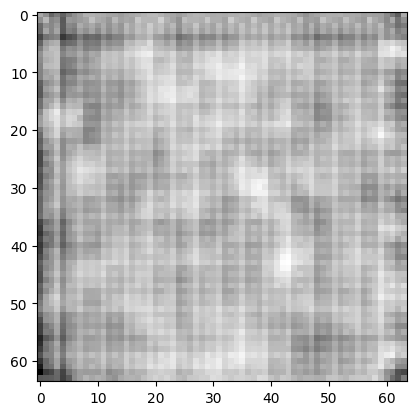

In [68]:
encoded, _ = model.encode(X_test[12].reshape((1, 64, 64, 1)))
decoded = model.decoder.predict(encoded)
plt.imshow(decoded.reshape((64, 64, 1)), cmap='gray')

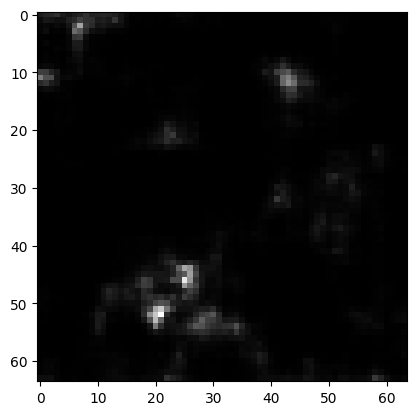

In [73]:
random = tf.random.uniform((1, 1024))
image = model.sample(random)
plt.imshow(image.numpy().reshape(64, 64, 1), cmap='gray')

# VAE 5

In [118]:
X_train_vae = X_train / 255.
X_valid_vae = X_val / 255.
X_test_vae = X_test / 255.

In [119]:
# zainspirowane wykładem
# inspired by https://github.com/shashankdhar/VAE-MNIST/blob/master/VAE.py
def latent_reparam_sampling(args):
    z_mean_layer, z_log_var_layer = args
    batch_size = K.shape(z_mean_layer)[0]
    data_size = K.int_shape(z_mean_layer)[1]
    epsilon = K.random_normal(shape=(batch_size, data_size))
    return z_mean_layer + K.exp(0.5 * z_log_var_layer) * epsilon

In [120]:
class DeepVae(tf.keras.Model):
    def __init__(self, latent_dimension):
        super(DeepVae, self).__init__()

        self.latent_dimension = latent_dimension

        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(64, 64, 1)),
            tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(self.latent_dimension + self.latent_dimension),
        ], name='encoder')

        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.latent_dimension,)),
            tf.keras.layers.Dense(units=16*16*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(16, 16, 32)),
            tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same'),
        ], name='decoder')

    def get_z_man_and_z_log_var(self, x):
        z_mean, z_logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return z_mean, z_logvar
            
    # @tf.function
    # def sample(self, eps=None):
    #     if eps is None:
    #         eps = tf.random.normal(shape=(100, self.latent_dim))
    #     return self.decode(eps, apply_sigmoid=True)

    # def encode(self, x):
    #     mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    #     return mean, logvar

    # def reparameterize(self, mean, logvar):
    #     eps = tf.random.normal(shape=mean.shape)
    #     return eps * tf.exp(logvar * .5) + mean

    # def decode(self, z, apply_sigmoid=False):
    #     logits = self.decoder(z)
    #     if apply_sigmoid:
    #         probs = tf.sigmoid(logits)
    #         return probs
    #     return logits

In [121]:
# def log_normal_pdf(sample, mean, logvar, raxis=1):
#     log2pi = tf.math.log(2. * np.pi)
#     return tf.reduce_sum(-0.5 * ((sample - mean) ** 2.0 * tf.exp(-logvar) + logvar + log2pi), axis=raxis)


# def compute_loss(model, x, beta = 1.0):
#     mean, logvar = model.encode(x)
#     z = model.reparameterize(mean, logvar)
#     x_logit = model.decode(z)
#     cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
#     logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
#     logpz = log_normal_pdf(z, 0., 0.)
#     logqz_x = log_normal_pdf(z, mean, logvar)
#     return -tf.reduce_mean(logpx_z + beta * (logpz - logqz_x))


# @tf.function
# def train_step(model, x, optimizer, beta = 1.0):
#     with tf.GradientTape() as tape:
#         loss = compute_loss(model, x, beta)
#     gradients = tape.gradient(loss, model.trainable_variables)
#     optimizer.apply_gradients(zip(gradients, model.trainable_variables))

@tf.function
def train_step(model, x, optimizer, beta=1.0):
    with tf.GradientTape() as tape:
        z_mean, z_log_var = tf.split(model.encoder(x), num_or_size_splits=2, axis=1)
        x_p = model.decoder(latent_reparam_sampling((z_mean, z_log_var)))
        # loss_reconstruction = K.sum(K.binary_crossentropy(x, x_p), axis=-1)
                
        loss_reconstruction = K.mean(K.square(x - x_p), axis=-1)
        
        loss_KL = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
        loss_KL = -0.5 * K.sum(loss_KL, axis=-1)
        loss = K.mean(loss_reconstruction) + beta * loss_KL
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [122]:
epochs = 10
annealing_cycles = 10
latent_dimension = 1024

In [123]:
model = DeepVae(latent_dimension)
model.encoder.summary()
model.decoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 31, 31, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 15, 15, 64)        18496     
                                                                 
 flatten_3 (Flatten)         (None, 14400)             0         
                                                                 
 dense_6 (Dense)             (None, 2048)              29493248  
                                                                 
Total params: 29512064 (112.58 MB)
Trainable params: 29512064 (112.58 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #  

In [124]:
optimizer = tf.keras.optimizers.Adam(1e-4)

train_size = X_train.shape[0]
val_size = X_val.shape[0]
test_size = X_test.shape[0]

batch_size = 128

train_dataset = (tf.data.Dataset.from_tensor_slices(X_train_vae.astype(np.float32)).shuffle(train_size).batch(batch_size))
val_dataset = (tf.data.Dataset.from_tensor_slices(X_valid_vae.astype(np.float32)).shuffle(val_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(X_test_vae.astype(np.float32)).shuffle(test_size).batch(batch_size))

In [125]:
annealing_cycle_length = epochs // annealing_cycles

for epoch in range(1, epochs + 1):
    start_time = time.time()
    beta = float(int(epoch) % int(annealing_cycle_length)) / annealing_cycle_length
    for train_x in train_dataset:
        train_step(model, train_x, optimizer, beta)
    end_time = time.time()
    print(f'epoch {epoch}')

  # loss = tf.keras.metrics.Mean()
  # for val_x in test_dataset:
  #   loss(compute_loss(model, val_x, beta))
  # elbo = -loss.result()
  # print('Epoch: {}, Validation set ELBO: {}, beta: {}, time elapse for current epoch: {}'
  #       .format(epoch, elbo, beta, end_time - start_time))

epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10


In [132]:
import matplotlib.pyplot as plt

def compare_images(image, generated_image):

    fig, ax = plt.subplots(1,2, figsize=(12,6))

    ax[0].imshow(image, cmap='gray')
    ax[0].set_title('Image')
    ax[1].imshow(generated_image, cmap='gray')
    ax[1].set_title('Generated image')

    plt.show()

In [133]:
def generate_image(image):
    encoded = model.encoder(image.reshape((1, 64, 64, 1)))
    args = tf.split(encoded, num_or_size_splits=2, axis=1)
    encoded = latent_reparam_sampling(args)
    return model.decoder.predict(encoded)

1/1 [==============================] - 0s 17ms/step


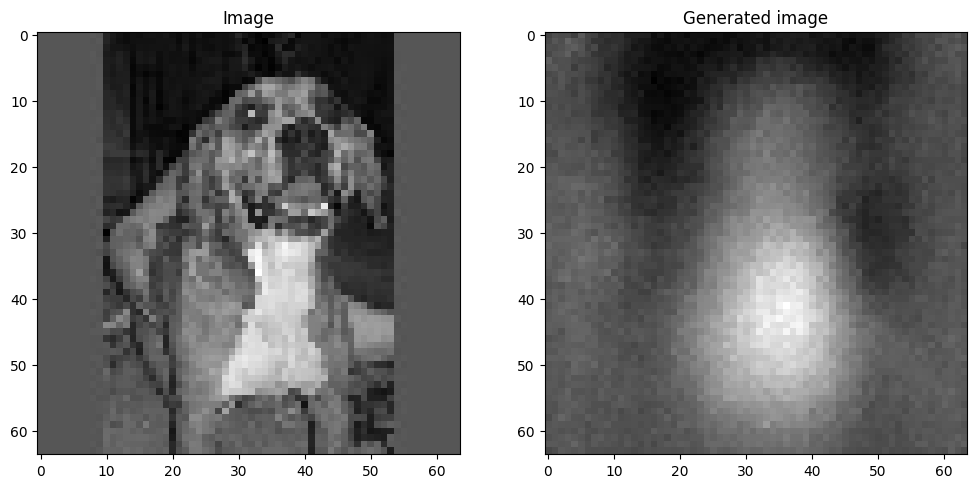

In [142]:
sample_size = 1

sample = np.random.randint(0, X_test.shape[0], sample_size)
for i in range(sample_size):
    decoded = generate_image(X_test[sample[i]])[0]
    compare_images(X_test[sample[i]], decoded)

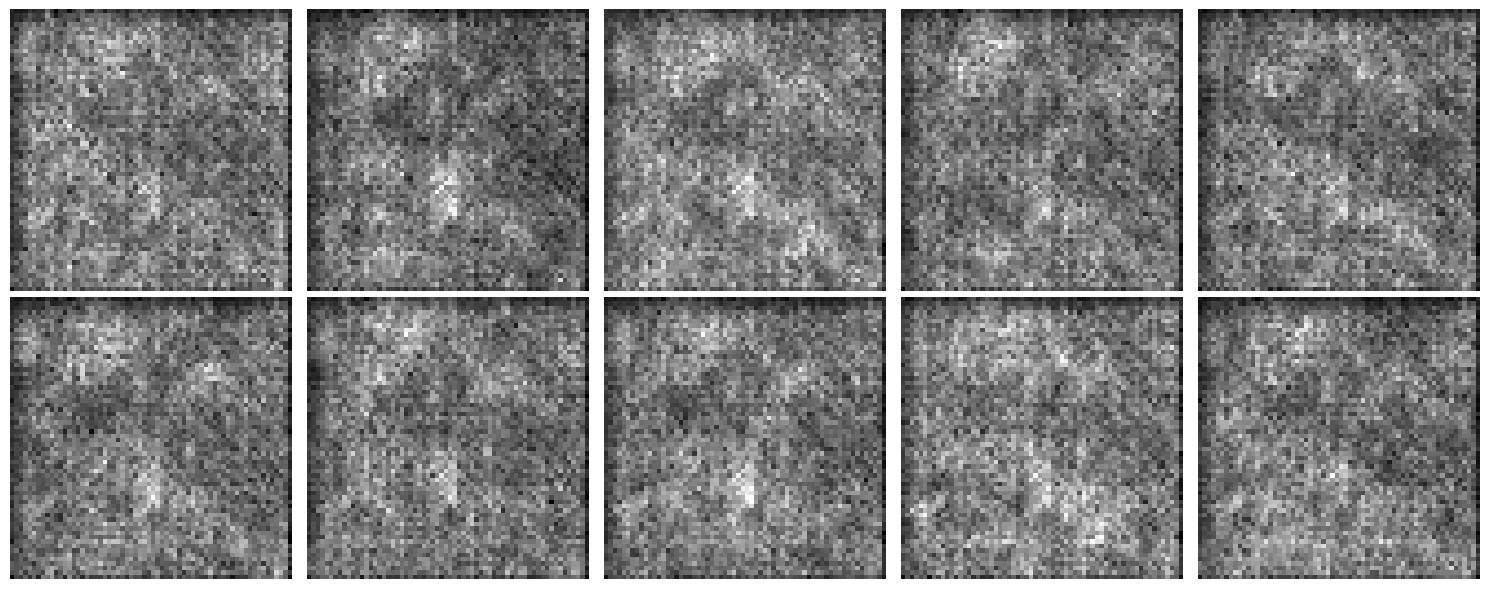

In [141]:
image_to_generate_count = 10
random_representations = [tf.random.uniform((1, 1024)) for _ in range(image_to_generate_count)]

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))

for i, representation in enumerate(random_representations):
    image = model.decoder(representation)
    ax = axes[i // 5, i % 5]
    ax.imshow(image.numpy().reshape(64, 64, 1), cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

# single image plot
# plt.imshow(decoded.reshape((64, 64, 1)), cmap='gray')